Now the dataset is composed of 5 subtypes of lung cancer and it is severely imbalanced. I have developped a round robin approach using forward features selection and either logistic regression or random forest as classifiers.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn import preprocessing
from numpy import cov
import scipy.linalg as la
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

df = pd.read_excel(r'C:\Users\p-emm\Desktop\Stage_M1\Base_de_données\Features of IA subtypes.xlsx')
df = df.sample(frac=1)
X = df.iloc[:,1:-1]
Y = df.iloc[:,-1]

X = X.values
Y = Y.values

In [49]:
X = X.T
#Preprocessing the data by removing the outliers using the interquartile range method
for index_element,element in enumerate(X):
    Q1=np.percentile(element,25)
    Q3=np.percentile(element,75)
    med = np.percentile(element,50)
    IQR = Q3-Q1
    for index_value,value in enumerate(element):
        if value < (Q1 - 1.5 * IQR) or value > (Q3 + 1.5 * IQR):
            X[index_element,index_value] = med
X=X.T
#Seperating the data into a training set and a validation set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=5,shuffle=True,stratify=Y)

#Scaling the data
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)



X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)

C:\Users\p-emm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\p-emm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Since some subtypes are under-represented and the dataset not large enough, we are going to proceed to upsampling.

In [50]:
### STANDARD UPSAMPLING

X_conc = pd.concat([X_train,Y_train],axis=1)

little_y = X_conc.iloc[:,-1]

lepidic = X_conc.loc[little_y == 1]
acinar = X_conc.loc[little_y == 3]
papillary = X_conc.loc[little_y == 2]
micro_papillary = X_conc.loc[little_y == 4]
solid = X_conc.loc[little_y == 5]

lepidic = resample(lepidic,replace=True,n_samples=60,random_state=27)

acinar = resample(acinar,replace=True,n_samples=58,random_state=27)

papillary = resample(papillary,replace=True,n_samples=52,random_state=27)

micro_papillary = resample(micro_papillary,replace=True,n_samples=49,random_state=7)

solid = resample(solid,replace=True,n_samples=40,random_state=2)

upsampled = pd.concat([lepidic,acinar,papillary,micro_papillary,solid])
upsampled = upsampled.sample(frac=1)
X_train = upsampled.iloc[:,:-1]
Y_train = upsampled.iloc[:,-1]
X_train = X_train.values
Y_train = Y_train.values

X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)

(39, 831)
(36, 831)
(13, 831)
(11, 831)
(9, 831)


In [51]:
#Reassembling the dataset together
X_conc = pd.concat([X_train,Y_train],axis=1)
little_y = X_conc.iloc[:,-1]

lepidic = X_conc.loc[little_y == 1]
papillary = X_conc.loc[little_y == 2]
acinar = X_conc.loc[little_y == 3]
micro_papillary = X_conc.loc[little_y == 4]
solid = X_conc.loc[little_y == 5]

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

Round-Robin consists in building a binary classifier for every possible combination of two subtypes:

In [53]:
#Lepidic and Acinar subtypes (LA)
LA = pd.concat([lepidic,acinar])
LA = LA.sample(frac=1)
X_LA_train = LA.iloc[:,:-1]
X_LA_train = X_LA_train.values
Y_LA_train = LA.iloc[:,-1]
Y_LA_train = Y_LA_train.values

#Using Forward Feature Selection with KNN approach
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform',n_jobs=-1)
sfs1 = sfs(knn, 
           k_features=5, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs1 = sfs1.fit(X_LA_train, Y_LA_train)
feat_cols_1 = list(sfs1.k_feature_idx_) #list containing the selected features

#Implementing the Binary Classifier for Lepidic and Acinar subtypes
rfc1 = RandomForestClassifier(n_estimators=30, random_state=42, max_features=2)
# rfc1 = LogisticRegression(C=50, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc1.fit(X_LA_train[:, feat_cols_1], Y_LA_train)

print(rfc1.score(X_LA_train[:, feat_cols_1],Y_LA_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:  2.5min finished

[2019-09-02 02:26:12] Features: 1/5 -- score: 0.95[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2019-09-02 02:28:40] Features: 2/5 -- score: 0.975[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 |

1.0


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished

[2019-09-02 02:35:49] Features: 5/5 -- score: 0.9833333333333334

We now use the exact same approach for the next couples of subtypes (Lepidic and Micro-Papillary, etc .)

In [54]:
LM = pd.concat([lepidic,micro_papillary])
LM = LM.sample(frac=1)
X_LM_train = LM.iloc[:,:-1]
X_LM_train = X_LM_train.values
Y_LM_train = LM.iloc[:,-1]
Y_LM_train= Y_LM_train.values

knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance',n_jobs=-1)

sfs2 = sfs(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs2 = sfs2.fit(X_LM_train, Y_LM_train)
feat_cols_2 = list(sfs2.k_feature_idx_)

# rfc2 = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=4)
rfc2 = LogisticRegression(C=5, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc2.fit(X_LM_train[:, feat_cols_2], Y_LM_train)

print(rfc2.score(X_LM_train[:, feat_cols_2],Y_LM_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:  2.3min finished

[2019-09-02 02:38:05] Features: 1/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2019-09-02 02:40:26] Features: 2/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | el

0.9908256880733946


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished

[2019-09-02 02:42:49] Features: 3/3 -- score: 1.0

In [55]:
LP = pd.concat([lepidic,papillary])
LP = LP.sample(frac=1)
X_LP_train = LP.iloc[:,:-1]
X_LP_train = X_LP_train.values
Y_LP_train = LP.iloc[:,-1]
Y_LP_train = Y_LP_train.values

knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance',n_jobs=-1)

sfs3 = sfs(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs3 = sfs3.fit(X_LP_train, Y_LP_train)
feat_cols_3 = list(sfs3.k_feature_idx_)

rfc3 = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=5)
# rfc3 = LogisticRegression(C=100, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc3.fit(X_LP_train[:, feat_cols_3], Y_LP_train)

print(rfc3.score(X_LP_train[:, feat_cols_3],Y_LP_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:  2.4min finished

[2019-09-02 02:45:11] Features: 1/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished

[2019-09-02 02:47:34] Features: 2/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | el

1.0


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished

[2019-09-02 02:49:29] Features: 3/3 -- score: 1.0

In [56]:
LS = pd.concat([lepidic,solid])
LS = LS.sample(frac=1)
X_LS_train = LS.iloc[:,:-1]
X_LS_train = X_LS_train.values
Y_LS_train = LS.iloc[:,-1]
Y_LS_train = Y_LS_train.values

knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance',n_jobs=-1)

sfs4 = sfs(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=9)

sfs4 = sfs4.fit(X_LS_train, Y_LS_train)
feat_cols_4 = list(sfs4.k_feature_idx_)

# rfc4 = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=4)
rfc4 = LogisticRegression(C=1, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc4.fit(X_LS_train[:, feat_cols_4], Y_LS_train)

print(rfc4.score(X_LS_train[:, feat_cols_4],Y_LS_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:  1.8min finished

[2019-09-02 02:51:15] Features: 1/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-09-02 02:52:59] Features: 2/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | el

1.0


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished

[2019-09-02 02:54:44] Features: 3/3 -- score: 1.0

In [57]:
AM = pd.concat([micro_papillary,acinar])
AM = AM.sample(frac=1)
X_AM_train = AM.iloc[:,:-1]
X_AM_train = X_AM_train.values
Y_AM_train = AM.iloc[:,-1]
Y_AM_train = Y_AM_train.values

# knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance',n_jobs=-1)
knn = LinearSVC(C=0.00001 , class_weight='balanced',max_iter=10000)

sfs5 = sfs(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs5 = sfs5.fit(X_AM_train, Y_AM_train)
feat_cols_5 = list(sfs5.k_feature_idx_)

rfc5 = RandomForestClassifier(n_estimators=30, random_state=42, max_depth=10)
# rfc5 = LogisticRegression(C=50, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc5.fit(X_AM_train[:, feat_cols_5], Y_AM_train)

print(rfc5.score(X_AM_train[:, feat_cols_5],Y_AM_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:    8.9s finished

[2019-09-02 02:54:53] Features: 1/3 -- score: 0.876868686868687[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-09-02 02:55:01] Features: 2/3 -- score: 0.876868686868687[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


1.0


[Parallel(n_jobs=1)]: Done 828 out of 828 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2019-09-02 02:55:09] Features: 3/3 -- score: 0.8677777777777779

In [58]:
AP = pd.concat([papillary,acinar])
AP = AP.sample(frac=1)
X_AP_train = AP.iloc[:,:-1]
X_AP_train = X_AP_train.values
Y_AP_train = AP.iloc[:,-1]
Y_AP_train = Y_AP_train.values

# knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
knn = LinearSVC(C=0.001 , class_weight='balanced',max_iter=10000)

sfs6 = sfs(knn, 
           k_features=5, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs6 = sfs6.fit(X_AP_train, Y_AP_train)
feat_cols_6 = list(sfs6.k_feature_idx_)

rfc6 = RandomForestClassifier(n_estimators=30, random_state=42, max_depth=10)
# rfc6 = LogisticRegression(C=0.0005, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc6.fit(X_AP_train[:, feat_cols_6], Y_AP_train)

print(rfc6.score(X_AP_train[:, feat_cols_6],Y_AP_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:    7.8s finished

[2019-09-02 02:55:17] Features: 1/5 -- score: 0.6609090909090909[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-09-02 02:55:25] Features: 2/5 -- score: 0.6740909090909091[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs

1.0


[Parallel(n_jobs=1)]: Done 826 out of 826 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2019-09-02 02:55:51] Features: 5/5 -- score: 0.8277272727272728

In [59]:
AS = pd.concat([solid,acinar])
AS = AS.sample(frac=1)
X_AS_train = AS.iloc[:,:-1]
X_AS_train = X_AS_train.values
Y_AS_train = AS.iloc[:,-1]
Y_AS_train = Y_AS_train.values

knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')

sfs7 = sfs(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=9)

sfs7 = sfs7.fit(X_AS_train, Y_AS_train)
feat_cols_7 = list(sfs7.k_feature_idx_)

rfc7 = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=4)
# rfc7 = LogisticRegression(C=1000, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc7.fit(X_AS_train[:, feat_cols_7], Y_AS_train)

print(rfc7.score(X_AS_train[:, feat_cols_7],Y_AS_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:    9.6s finished

[2019-09-02 02:56:01] Features: 1/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-09-02 02:56:11] Features: 2/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


1.0


[Parallel(n_jobs=1)]: Done 828 out of 828 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2019-09-02 02:56:20] Features: 3/3 -- score: 1.0

In [60]:
MP = pd.concat([micro_papillary,papillary])
MP = MP.sample(frac=1)
X_MP_train = MP.iloc[:,:-1]
X_MP_train = X_MP_train.values
Y_MP_train = MP.iloc[:,-1]
Y_MP_train = Y_MP_train.values

knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')

sfs8 = sfs(knn, 
           k_features=4, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs8 = sfs8.fit(X_MP_train, Y_MP_train)
feat_cols_8 = list(sfs8.k_feature_idx_)

rfc8 = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10)
# rfc8 = LogisticRegression(C=100, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc8.fit(X_MP_train[:, feat_cols_8], Y_MP_train)

print(rfc8.score(X_MP_train[:, feat_cols_8],Y_MP_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:   10.4s finished

[2019-09-02 02:56:31] Features: 1/4 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-09-02 02:56:41] Features: 2/4 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | el

1.0


[Parallel(n_jobs=1)]: Done 827 out of 827 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2019-09-02 02:57:04] Features: 4/4 -- score: 1.0

In [61]:
MS = pd.concat([micro_papillary,solid])
MS = MS.sample(frac=1)
X_MS_train = MS.iloc[:,:-1]
X_MS_train = X_MS_train.values
Y_MS_train = MS.iloc[:,-1]
Y_MS_train = Y_MS_train.values

# knn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform',n_jobs=-1)
knn = LinearSVC(C=0.00001 , class_weight='balanced',max_iter=10000)

sfs9 = sfs(knn, 
           k_features=5, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=9)

sfs9 = sfs9.fit(X_MS_train, Y_MS_train)
feat_cols_9 = list(sfs9.k_feature_idx_)

rfc9 = RandomForestClassifier(n_estimators=40, random_state=42, max_depth=5)
# rfc9 = LogisticRegression(C=100, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc9.fit(X_MS_train[:, feat_cols_9], Y_MS_train)

print(rfc9.score(X_MS_train[:, feat_cols_9],Y_MS_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:    7.9s finished

[2019-09-02 02:57:12] Features: 1/5 -- score: 0.6262626262626264[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-09-02 02:57:20] Features: 2/5 -- score: 0.8080808080808081[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs

1.0


[Parallel(n_jobs=1)]: Done 826 out of 826 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2019-09-02 02:57:41] Features: 5/5 -- score: 0.9326599326599327

In [62]:
PS = pd.concat([papillary,solid])
PS = PS.sample(frac=1)
X_PS_train = PS.iloc[:,:-1]
X_PS_train = X_PS_train.values
Y_PS_train = PS.iloc[:,-1]
Y_PS_train = Y_PS_train.values

knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance',n_jobs=-1)

sfs10 = sfs(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=9)

sfs10 = sfs10.fit(X_PS_train, Y_PS_train)
feat_cols_10 = list(sfs10.k_feature_idx_)

rfc10 = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10)
# rfc10 = LogisticRegression(C=0.01, penalty='l2',max_iter=5000,solver='liblinear',class_weight='balanced')
rfc10.fit(X_PS_train[:, feat_cols_10], Y_PS_train)

print(rfc10.score(X_PS_train[:, feat_cols_10],Y_PS_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:  1.7min finished

[2019-09-02 02:59:23] Features: 1/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 829 out of 829 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-09-02 03:01:03] Features: 2/3 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 828 out of 828 | el

1.0


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished

[2019-09-02 03:02:44] Features: 3/3 -- score: 1.0

Since each classifier is going to give a predicted output, we need to define voting strategies to know what is the actual output using the score matrix given by the confidence score each classifier has in its prediction:

In [63]:
def voting_strategy(M):
    max=0
    pred=1
    for i in range(len(M)):
        a=0
        for j in range(len(M)):
            if j!=i:
                if M[i][j] > M[j][i]:
                    s=1
                else:
                    s=0
                a=a+s
        if a>max:
            max=a
            pred=i
    return pred+1

#Taking into account the weight of the prediction score
def weighted_voting_strategy(M):
    max=0
    pred=1
    for i in range(len(M)):
        a=0
        for j in range(len(M)):
            if j!=i:
                a=a+M[i][j]
        if a>max:
            max=a
            pred=i
    return pred+1
#Voting strategy eliminating successively the least likely predicted ouputs
def output_strategy(M):
    for i in range(len(M)-2):
        a = np.sum(M, axis = 0)
        minimoume=np.inf
        for element in a:
            if element >0 and element < minimoume:
                minimoume = element
        b = np.where(a == minimoume)
        index = b[0][0]
        M[:,index] = 0
        M[index,:] = 0
    prediction = np.where(M.T == np.max(M))
    return prediction[0][0] +1

In [69]:
y_pred=[]
for index_element, element in enumerate(X_test):
    element_1 = element[feat_cols_1]
    element_2 = element[feat_cols_2]
    element_3 = element[feat_cols_3]
    element_4 = element[feat_cols_4]
    element_5 = element[feat_cols_5]
    element_6 = element[feat_cols_6]
    element_7 = element[feat_cols_7]
    element_8 = element[feat_cols_8]
    element_9 = element[feat_cols_9]
    element_10 = element[feat_cols_10]
    
    element_1= element_1.reshape(1, -1)
    element_2= element_2.reshape(1, -1)
    element_3= element_3.reshape(1, -1)
    element_4= element_4.reshape(1, -1)
    element_5= element_5.reshape(1, -1)
    element_6= element_6.reshape(1, -1)
    element_7= element_7.reshape(1, -1)
    element_8= element_8.reshape(1, -1)
    element_9= element_9.reshape(1, -1)
    element_10= element_10.reshape(1, -1)
    
    score_matrix = np.zeros((5,5))
    score_matrix[0][2] = rfc1.predict_proba(element_1)[0][0]
    score_matrix[0][3] = rfc2.predict_proba(element_2)[0][0]
    score_matrix[0][1] = rfc3.predict_proba(element_3)[0][0]
    score_matrix[0][4] = rfc4.predict_proba(element_4)[0][0]
    score_matrix[2][3] = rfc5.predict_proba(element_5)[0][0]
    score_matrix[1][2] = rfc6.predict_proba(element_6)[0][0]
    score_matrix[2][4] = rfc7.predict_proba(element_7)[0][0]
    score_matrix[1][3] = rfc8.predict_proba(element_8)[0][0]
    score_matrix[3][4] = rfc9.predict_proba(element_9)[0][0]
    score_matrix[1][4] = rfc10.predict_proba(element_10)[0][0]
    
    for i in range(1,5):
        for j in range(i):
            score_matrix[i][j] = 1-score_matrix[j][i]
#     y_pred.append(voting_strategy(score_matrix))
    y_pred.append(weighted_voting_strategy(score_matrix))
#     y_pred.append(output_strategy(score_matrix.T))
    
    
print(np.array(y_pred))
print(Y_test)
print(np.array(y_pred-Y_test))

print(accuracy_score(Y_test, y_pred))

[3 3 3 1 4 3 3 3 1 1 3 3 3 4 1 1 1 3 1 4 3 1 1 1 3 1 4 1]
[2 4 3 1 5 3 3 3 1 1 3 2 3 5 1 1 1 3 1 4 5 3 2 1 3 1 4 1]
[ 1 -1  0  0 -1  0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0 -2 -2 -1  0
  0  0  0  0]
0.7142857142857143


In [65]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

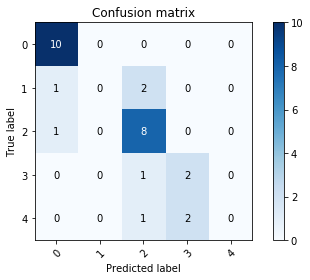

In [66]:
plot_confusion_matrix(Y_test, y_pred,title='Confusion matrix')